## Examining Factor Return Performance

In [1]:
import warnings

In [2]:
import alphalens
import pandas as pd
from alphalens.performance import (
    compute_mean_returns_spread,
    cumulative_returns,
    factor_alpha_beta,
    factor_cumulative_returns,
    factor_returns,
    mean_return_by_quantile,
)
from alphalens.utils import get_clean_factor_and_forward_returns
from IPython.display import Markdown, display

In [3]:
warnings.filterwarnings("ignore")

Load the mean reversion data

In [4]:
mean_reversion = pd.read_pickle("mean_reversion.pickle")

Construct a dataframe with symbols in the columns and dates in the rows for prices

In [5]:
prices = pd.concat(
    [df.to_frame(d) for d, df in mean_reversion.prices.dropna().items()], axis=1
).T

Convert column names to strings

In [6]:
prices.columns = [col.symbol for col in prices.columns]

Normalize Timestamp to midnight, preserving tz information

In [7]:
prices.index = prices.index.normalize()

Construct a dataframe with symbols in the columns and factor rank in the rows

In [8]:
factor_data = pd.concat(
    [df.to_frame(d) for d, df in mean_reversion.factor_data.dropna().items()], axis=1
).T

Convert column names to strings

In [9]:
factor_data.columns = [col.symbol for col in factor_data.columns]

Normalize Timestamp to midnight, preserving tz information

In [10]:
factor_data.index = factor_data.index.normalize()

Create a multiindex with date in level 0 and symbol in level 1

In [11]:
factor_data = factor_data.stack()

Rename the multiindexes

In [12]:
factor_data.index.names = ["date", "asset"]

Compile the forward returns, factor rank, and factor quantile using Alphalens

In [13]:
alphalens_data = get_clean_factor_and_forward_returns(
    factor=factor_data, prices=prices, periods=(5, 10, 21, 63)
)

Dropped 12.5% entries from factor data: 12.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Calculate and display factor returns

In [14]:
returns = factor_returns(alphalens_data)
display(returns)

,5D,10D,21D,63D
date,,,,
2016-01-04 00:00:00+00:00,-0.016253,-0.027134,-0.013492,-0.015658
2016-01-05 00:00:00+00:00,-0.016253,-0.027134,-0.013492,-0.015658
2016-01-06 00:00:00+00:00,-0.016253,-0.027134,-0.013492,-0.015658
2016-01-07 00:00:00+00:00,-0.016253,-0.027134,-0.026664,-0.015658
2016-01-08 00:00:00+00:00,-0.016253,-0.026459,-0.026664,-0.011788
...,...,...,...,...
2017-09-25 00:00:00+00:00,-0.003797,-0.001202,0.000069,0.000902
2017-09-26 00:00:00+00:00,-0.003797,-0.001202,0.000069,-0.006470
2017-09-27 00:00:00+00:00,-0.003797,-0.001202,0.000069,-0.006470


Calculate and display factor returns by asset

In [15]:
returns = factor_returns(alphalens_data, by_asset=True)
display(returns)

5D       10D       21D       63D
date                      asset                                        
2016-01-04 00:00:00+00:00 AAL   -0.000006  0.000078  0.000058 -0.000064
                          AAPL  -0.001374 -0.001751 -0.001797  0.001162
                          ABBV   0.000862  0.000605  0.000744 -0.000370
                          AET    0.000211  0.000237  0.000316  0.000380
                          AGN   -0.000052 -0.000100 -0.000158 -0.000191
...                                   ...       ...       ...       ...
2017-09-29 00:00:00+00:00 ADP   -0.000008 -0.000008 -0.000008 -0.000008
                          COL    0.000130  0.000285  0.000417  0.000417
                          BBY    0.000939  0.001407  0.001407  0.001407
                          EFX    0.000411  0.001081  0.000592  0.000444
                          SBAC   0.000143  0.000635  0.000635  0.000635

[43995 rows x 4 columns]

Plot cumulative returns

<Axes: xlabel='date'>

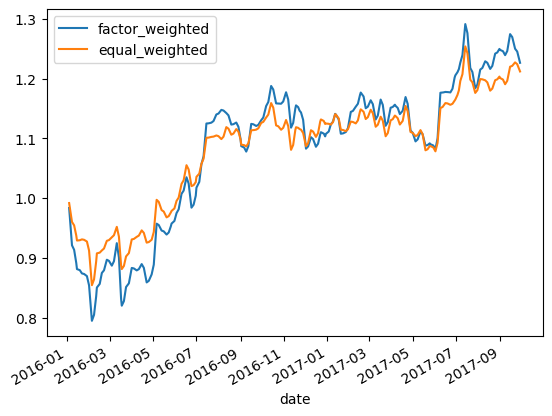

In [16]:
pd.concat(
    {
        "factor_weighted": factor_cumulative_returns(alphalens_data, period="5D"),
        "equal_weighted": factor_cumulative_returns(
            alphalens_data, period="5D", equal_weight=True
        ),
    },
    axis=1,
).plot()

Calculate and display mean return by quantile

,5D,10D,21D,63D
factor_quantile,,,,
1,-0.000195,-0.000131,0.000618,-0.001325
2,-0.000024,-0.001480,-0.002455,-0.002777
3,-0.000637,-0.001633,-0.001494,-0.003197
4,-0.000208,0.000304,-0.000007,0.001897
5,0.001063,0.002940,0.003341,0.005413


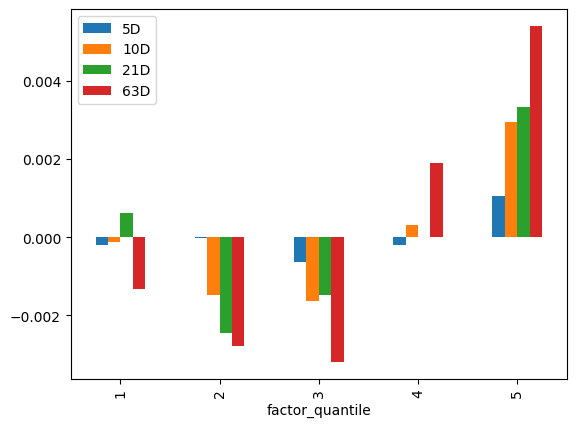

In [17]:
mean_returns, std_err = mean_return_by_quantile(alphalens_data)
mean_returns.plot.bar()
display(mean_returns)

Calculate mean returns by date and display return difference

In [18]:
mean_returns_by_date, _ = mean_return_by_quantile(alphalens_data, by_date=True)

In [19]:
mean_return_difference, _ = compute_mean_returns_spread(
    mean_returns=mean_returns_by_date,
    upper_quant=1,
    lower_quant=5,
)

<Axes: xlabel='date'>

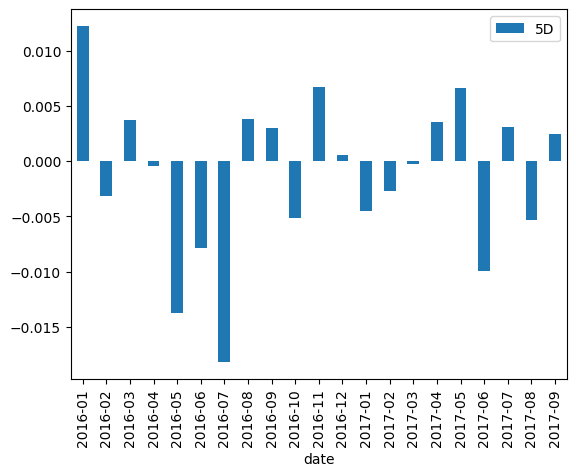

In [20]:
mean_return_difference[["5D"]].resample("M").mean().to_period("M").plot.bar()

Calculate and display alpha and beta

In [21]:
alpha_beta = factor_alpha_beta(alphalens_data)
display(alpha_beta)

,5D,10D,21D,63D
Ann. alpha,0.006204,0.015760,-0.003038,-0.012823
beta,0.136634,0.123627,0.117090,0.147144


**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.